## **Import Library**

In [2]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 16.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

## **Dataset Collection and Description**

In [4]:
df = pd.read_csv('Data/US_Accidents_March23_sampled_50k.csv')
df.shape
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [5]:
df['Severity'].value_counts()

Severity
2    40333
3     8494
4     1292
1      423
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50542 entries, 0 to 50541
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     50542 non-null  object 
 1   Source                 50542 non-null  object 
 2   Severity               50542 non-null  int64  
 3   Start_Time             50542 non-null  object 
 4   End_Time               50542 non-null  object 
 5   Start_Lat              50542 non-null  float64
 6   Start_Lng              50542 non-null  float64
 7   End_Lat                28102 non-null  float64
 8   End_Lng                28102 non-null  float64
 9   Distance(mi)           50542 non-null  float64
 10  Description            50542 non-null  object 
 11  Street                 50472 non-null  object 
 12  City                   50542 non-null  object 
 13  County                 50542 non-null  object 
 14  State                  50542 non-null  object 
 15  Zi

In [7]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,ID,object
1,Source,object
2,Severity,int64
3,Start_Time,object
4,End_Time,object
5,Start_Lat,float64
6,Start_Lng,float64
7,End_Lat,float64
8,End_Lng,float64
9,Distance(mi),float64


In [8]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,bool,6
1,int64,1
2,float64,12
3,object,27


## **Data Preprocessing**


*   Handling of missing values: Given the huge amount of data, the features containing null values >40% have been eliminated (for better prediction accuracy)
*   Checked for duplicates and dropped any if present using drop_duplicates()

The following 2 steps are conducted individually for each research question:
*   Convert Categorical columns to numerical using one-hot encoding/label encoding
*   Given the large number of features leveraged PCA for Dimensionality Reduction to select the optimal features that explain the most variance in the data


### **Handling Missing Values**

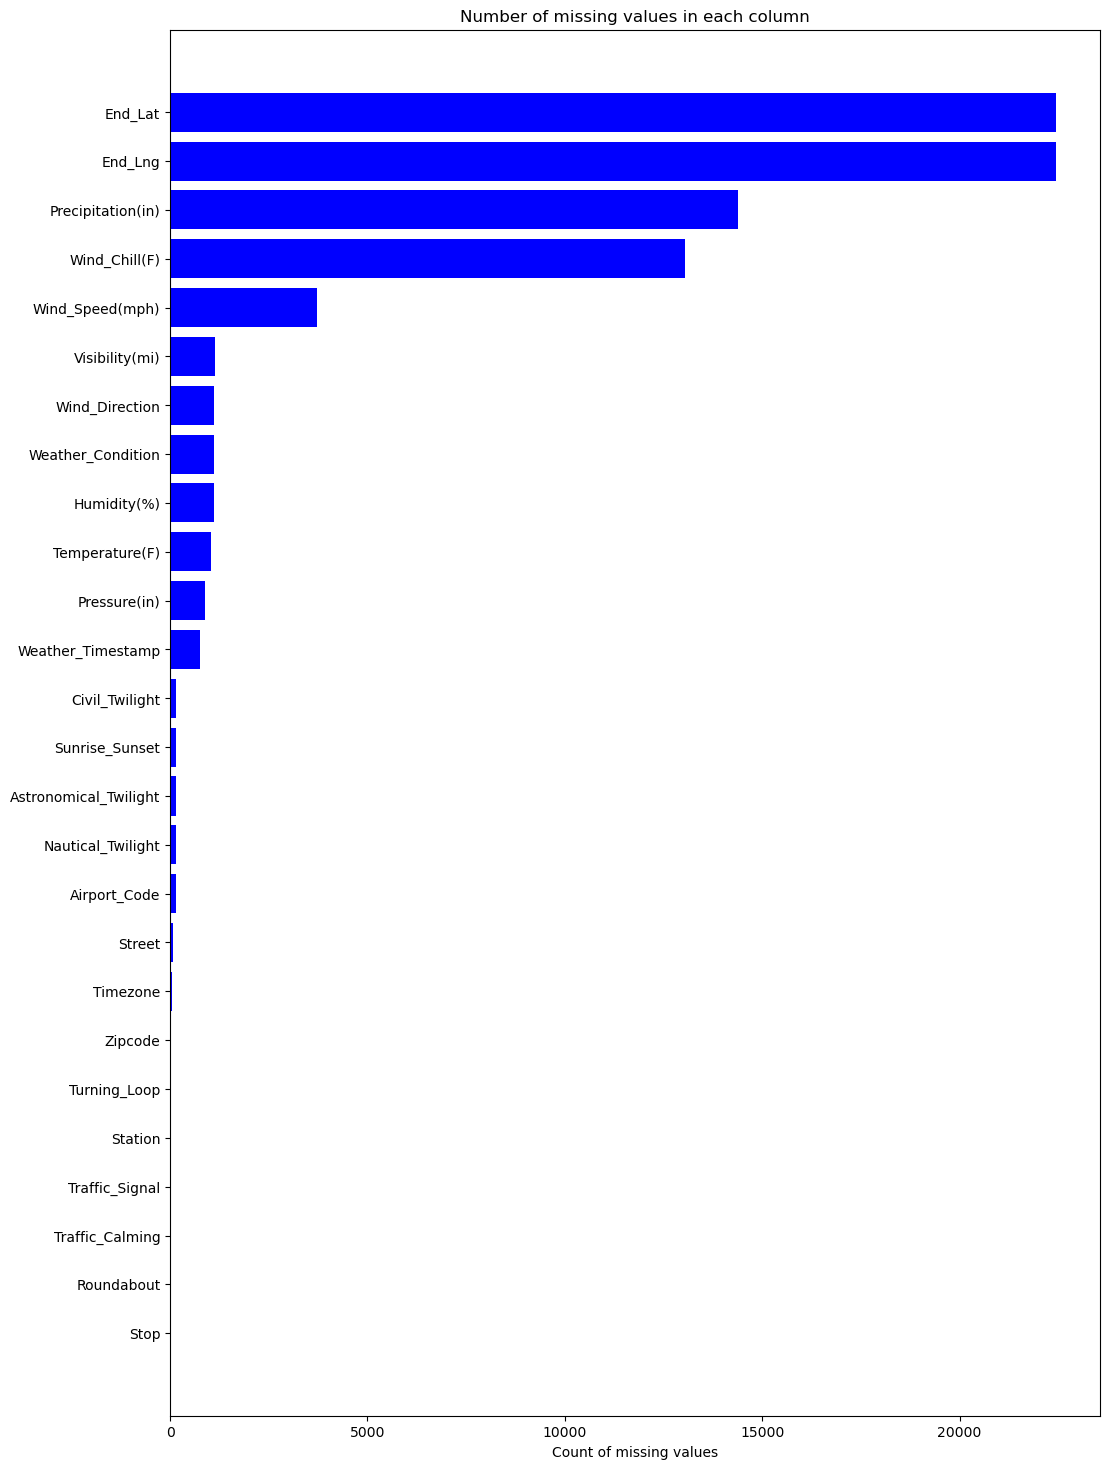

In [9]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name','missing_count']
missing_df = missing_df[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.5
fig,ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind,missing_df.missing_count.values,color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [10]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.4]

,columns_name,missing_count,missing_ratio
7,End_Lat,22440,0.443987
8,End_Lng,22440,0.443987


In [11]:
missin = missing_df.loc[missing_df['missing_ratio']>0.4]
removelist = missin['columns_name'].tolist()
removelist

['End_Lat', 'End_Lng']

In [12]:
df.drop(['End_Lat', 'End_Lng', 'ID'], axis=1, inplace=True)

In [13]:
df.shape

(50542, 43)

## **Research Question 1: What are the primary factors contributing to the severity of traffic collisions in the United States?**

Using Exploratory Data Analysis Techniques to answer this question.
Based on human judgement few features were identified to be tested for any potential relationship/dependency with the target variable - 'Severity'

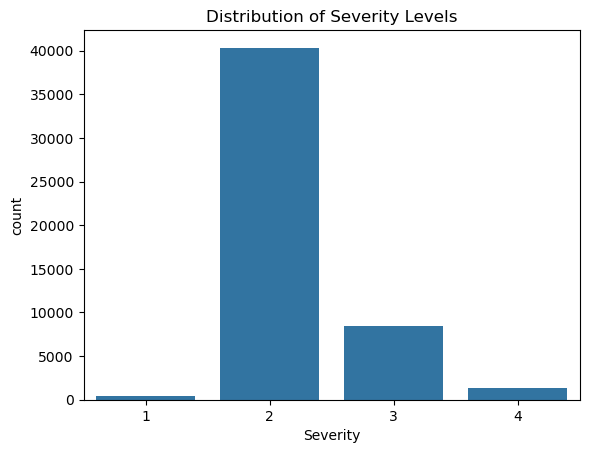

In [14]:
sns.countplot(x='Severity', data=df)
plt.title('Distribution of Severity Levels')
plt.show()

In [15]:
potential_factors = ['State', 'Visibility(mi)', 'Wind_Speed(mph)',
                    'Precipitation(in)', 'Amenity', 'Bump', 'Crossing',
                    'Give_Way', 'Junction', 'No_Exit', 'Sunrise_Sunset']

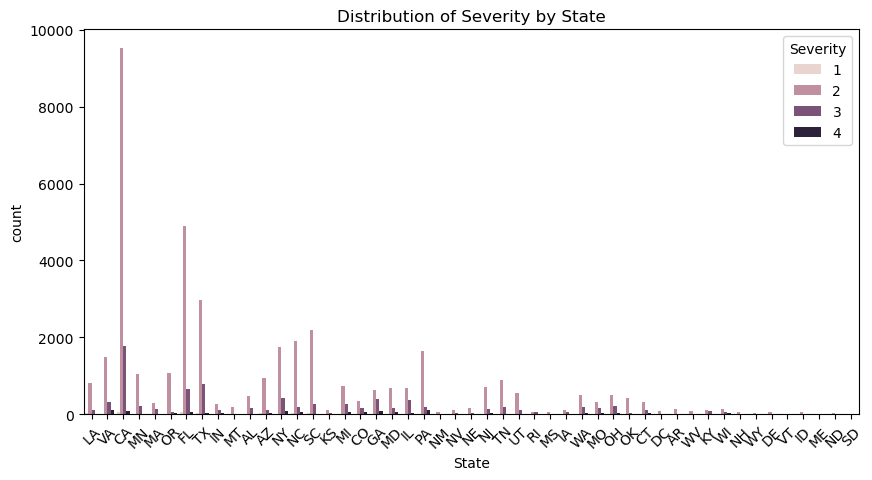

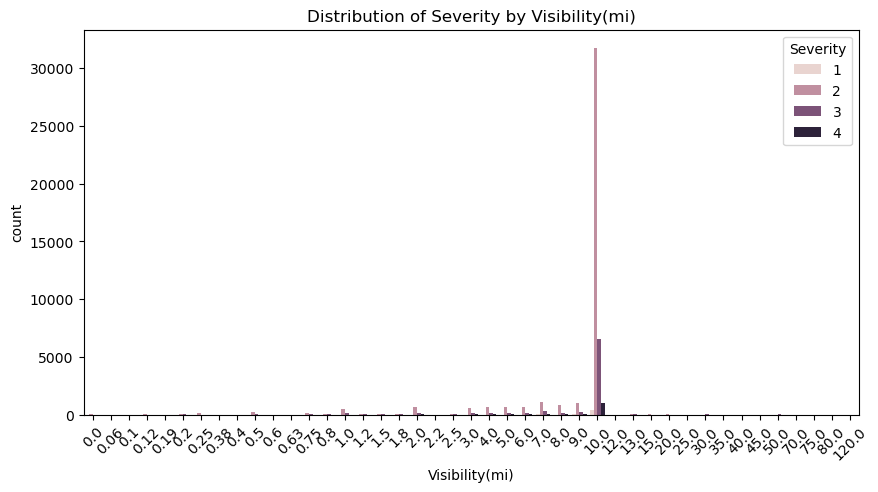

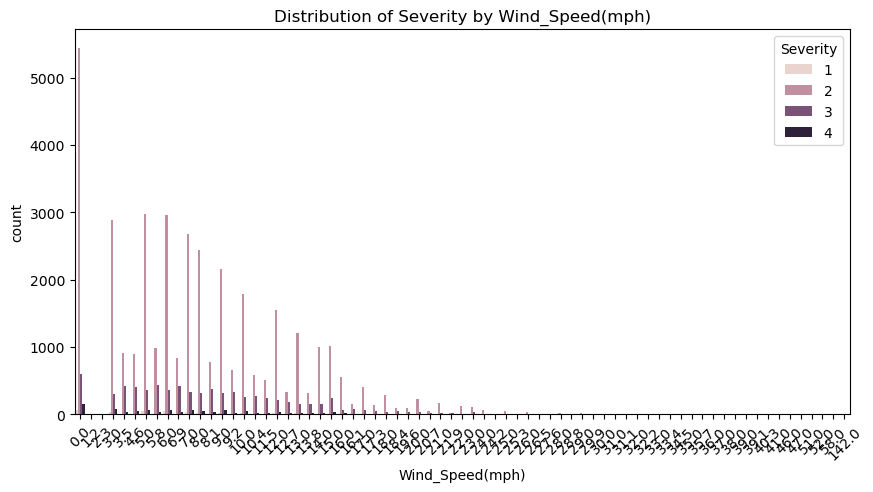

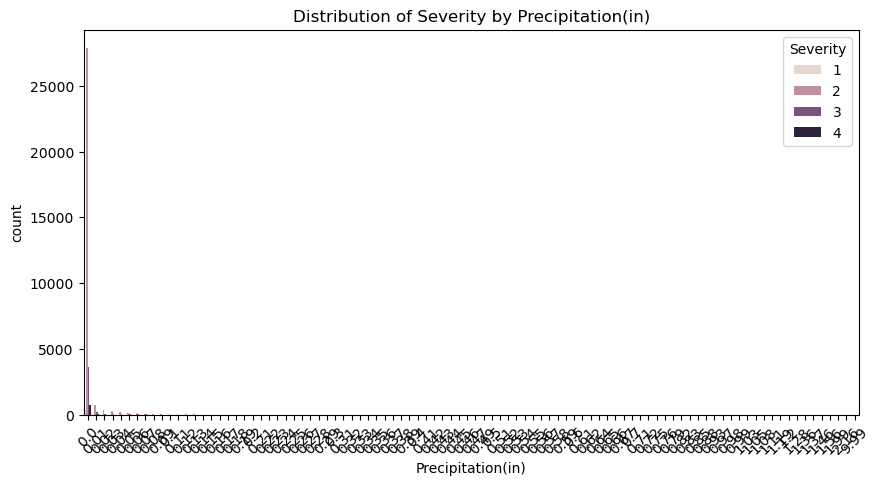

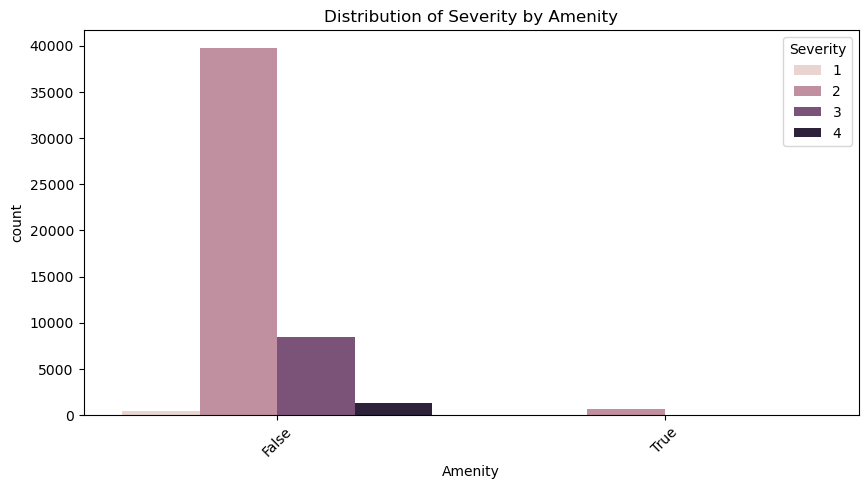

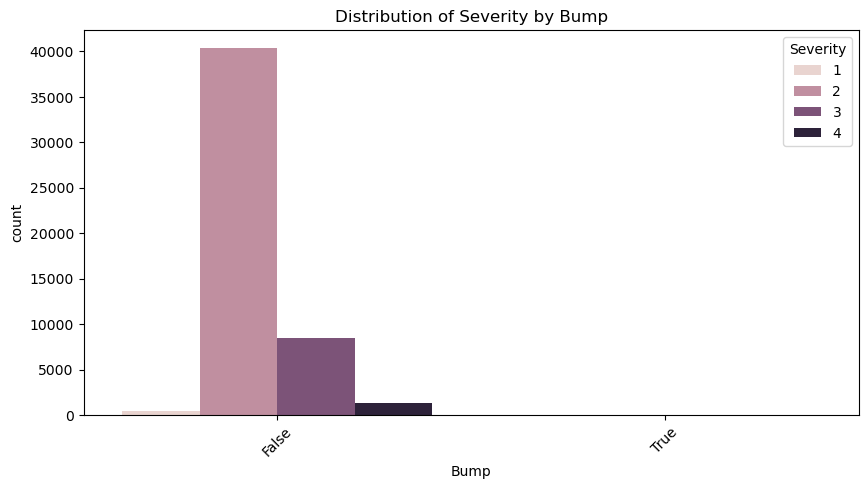

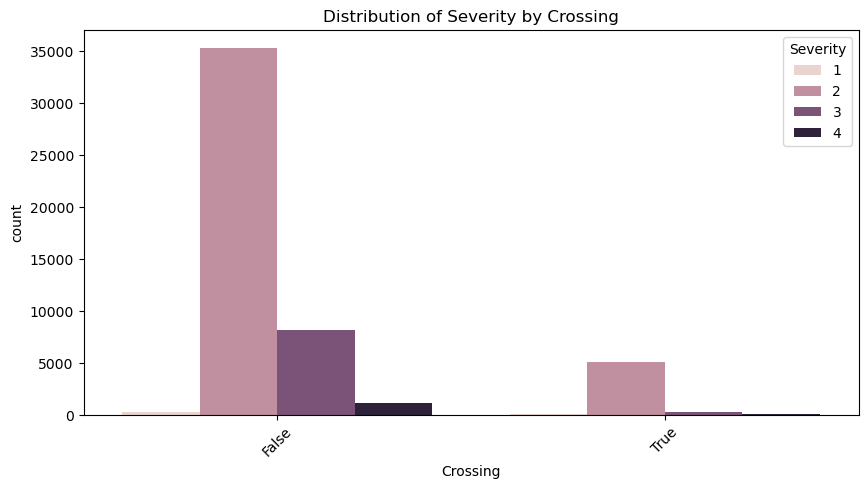

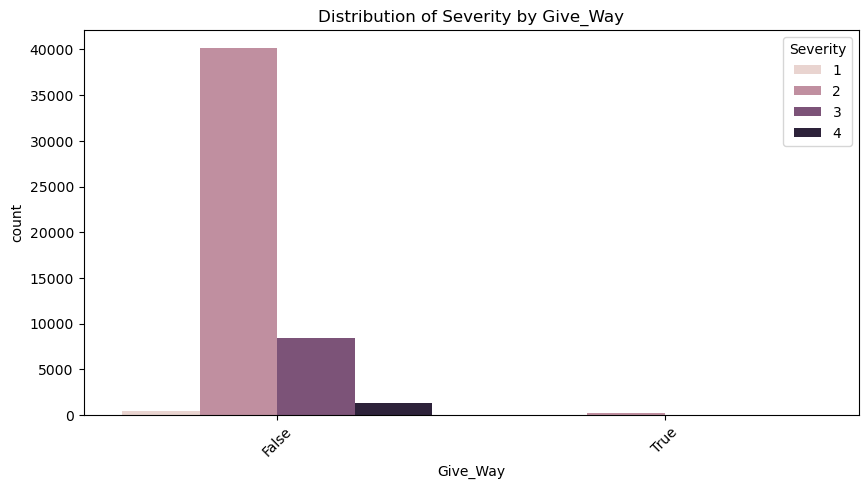

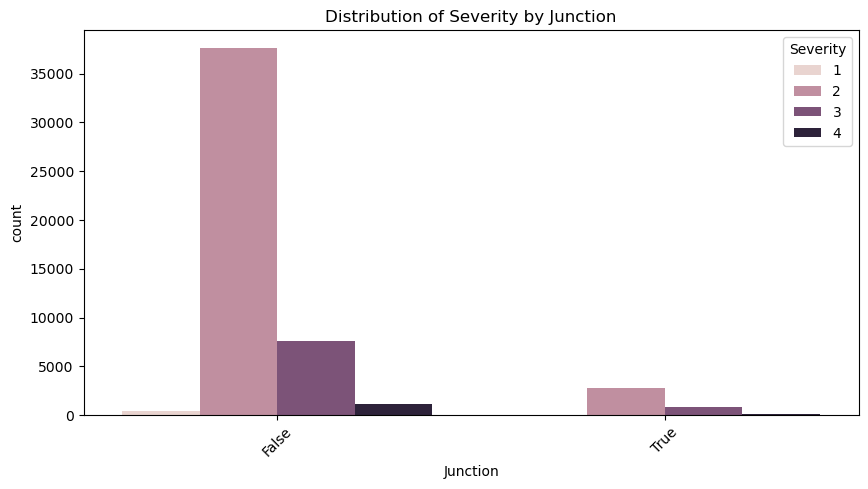

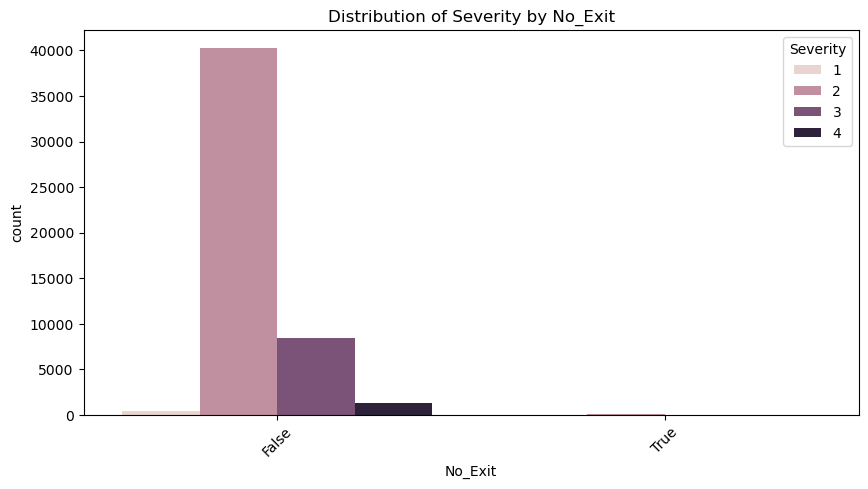

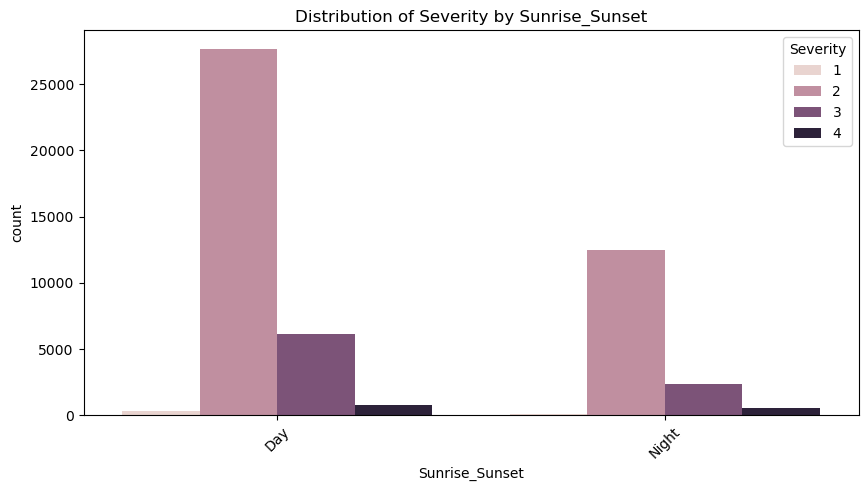

In [16]:
for factor in potential_factors:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=factor, hue='Severity', data=df)
    plt.title(f'Distribution of Severity by {factor}')
    plt.xticks(rotation=45)
    plt.show()

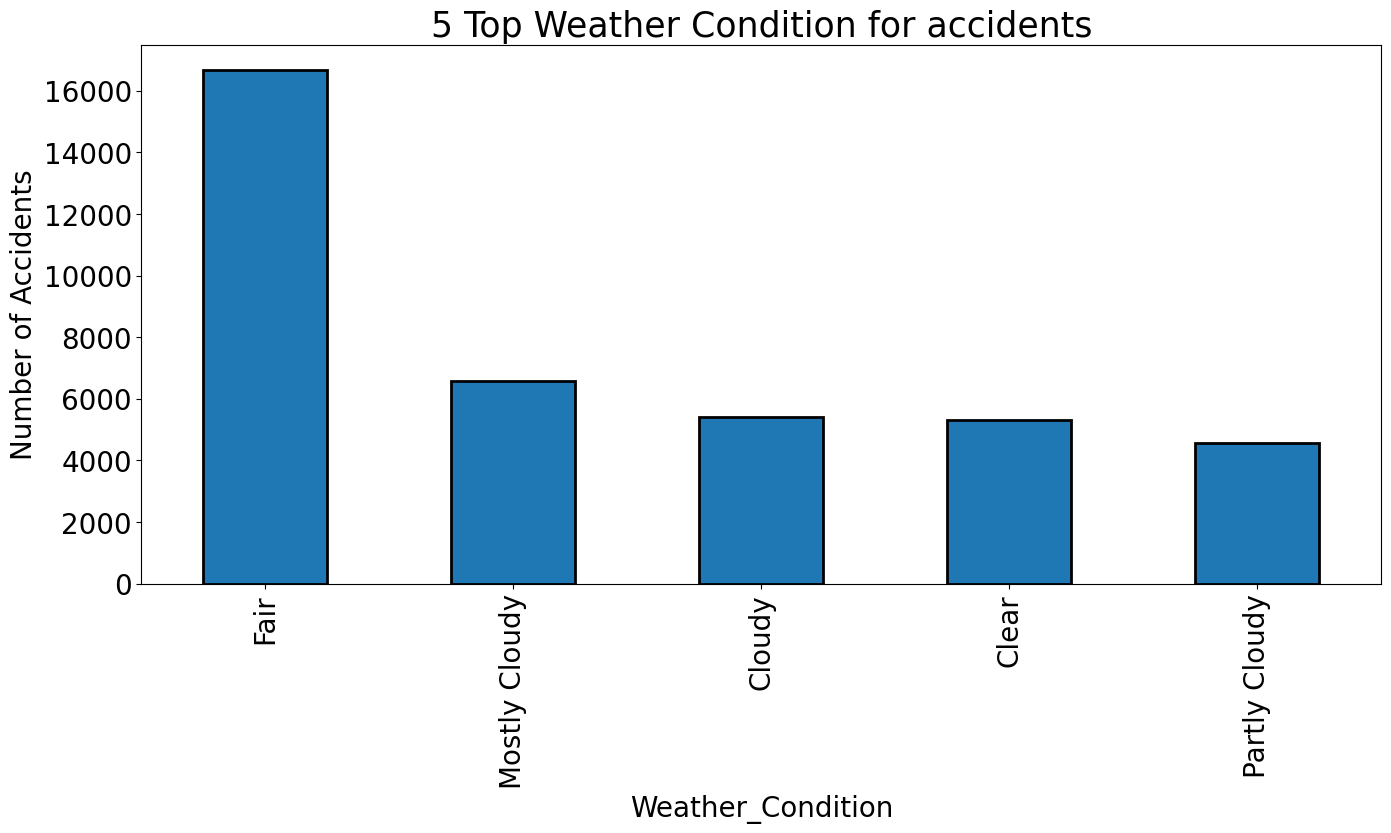

In [17]:
fig, ax=plt.subplots(figsize=(16,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(5).plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather_Condition',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('5 Top Weather Condition for accidents',fontsize=25)
plt.show()

## **Research Question 2: Can machine learning models effectively classify collision severity based on historical data?**

### **Encoding Categorical Data**

In [18]:
df.columns

Index(['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [19]:
df_encoded = df[['Severity', 'State', 'Timezone', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Sunrise_Sunset']]

In [20]:
df_encoded["Amenity"] = df_encoded["Amenity"].astype(int)
df_encoded["Bump"] = df_encoded["Bump"].astype(int)
df_encoded["Crossing"] = df_encoded["Crossing"].astype(int)
df_encoded["Give_Way"] = df_encoded["Give_Way"].astype(int)
df_encoded["Junction"] = df_encoded["Junction"].astype(int)
df_encoded["No_Exit"] = df_encoded["No_Exit"].astype(int)

In [21]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50542 entries, 0 to 50541
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Severity           50542 non-null  int64  
 1   State              50542 non-null  object 
 2   Timezone           50496 non-null  object 
 3   Temperature(F)     49496 non-null  float64
 4   Wind_Chill(F)      37487 non-null  float64
 5   Humidity(%)        49424 non-null  float64
 6   Pressure(in)       49659 non-null  float64
 7   Visibility(mi)     49414 non-null  float64
 8   Wind_Speed(mph)    46832 non-null  float64
 9   Precipitation(in)  36160 non-null  float64
 10  Amenity            50542 non-null  int64  
 11  Bump               50542 non-null  int64  
 12  Crossing           50542 non-null  int64  
 13  Give_Way           50542 non-null  int64  
 14  Junction           50542 non-null  int64  
 15  No_Exit            50542 non-null  int64  
 16  Sunrise_Sunset     503

In [22]:
df_encoded.dropna(inplace=True)

In [23]:
encoded_df = pd.get_dummies(df_encoded, columns=['State','Timezone','Sunrise_Sunset'], dtype=int)

In [24]:
encoded_df.head(2)

,Severity,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Amenity,Bump,...,State_WA,State_WI,State_WV,State_WY,Timezone_US/Central,Timezone_US/Eastern,Timezone_US/Mountain,Timezone_US/Pacific,Sunrise_Sunset_Day,Sunrise_Sunset_Night
0,2,77.0,77.0,62.0,29.92,10.0,5.0,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,2,45.0,43.0,48.0,29.91,10.0,5.0,0.0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [25]:
encoded_df.shape

(34146, 69)

### **Train-Test Split**

In [26]:
X = encoded_df.drop('Severity', axis=1)
y = encoded_df['Severity']

In [27]:
# Resample the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [28]:
# Splitting the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Optionally, you can print the shapes of the resulting sets to verify the split
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (93139, 68)
Shape of X_test: (23285, 68)
Shape of y_train: (93139,)
Shape of y_test: (23285,)


### **Dimensionality Reduction using PCA**

In [29]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Fit scaler to training data and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

In [30]:
# Apply PCA
pca = PCA(n_components=0.8)  # retain 80% variance in the data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Print the number of components retained
print("Number of components:", pca.n_components_)

# Optionally, you can also inspect the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

Number of components: 47
Explained variance ratio: [0.04576754 0.03732811 0.03251834 0.02940728 0.02260616 0.01999848
 0.01806074 0.01633394 0.01611359 0.0159324  0.01550524 0.01538409
 0.01517205 0.0151468  0.01501193 0.01498233 0.01492836 0.01491312
 0.01487619 0.01486381 0.01482698 0.01481477 0.01480879 0.01479964
 0.01478917 0.0147852  0.01477483 0.01477223 0.01476823 0.01476141
 0.01475572 0.01474425 0.01473808 0.0147345  0.01472973 0.01472752
 0.01472293 0.01472059 0.01471855 0.01471821 0.01471776 0.01471744
 0.01471465 0.01471283 0.01470937 0.01470899 0.0147082 ]


### **Logistic Regression**

In [31]:
# Instantiate the model
logistic_regression = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

# Train the model
logistic_regression.fit(X_train_pca, y_train)

# Predictions on the test set
y_pred_lr = logistic_regression.predict(X_test_pca)

# Evaluate the model (e.g., accuracy)
accuracy_lr = logistic_regression.score(X_test_pca, y_test)
print("Accuracy of Logistic Regression:", accuracy_lr)

Accuracy of Logistic Regression: 0.5669315009662873


### **Support Vector Machine**

In [37]:
"""
# Instantiate the model
svm = SVC()

# Train the model
svm.fit(X_train_pca, y_train)

# Predictions on the test set
y_pred_svm = svm.predict(X_test_pca)

# Evaluate the model (e.g., accuracy)
accuracy_svm = svm.score(X_test_pca, y_test)
print("Accuracy of SVM:", accuracy_svm)
"""

Accuracy of SVM: 0.6070431608331543


### **Random Forests**

In [32]:
# Instantiate the model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(X_train_pca, y_train)

# Predictions on the test set
y_pred_rf = random_forest.predict(X_test_pca)

# Evaluate the model (e.g., accuracy)
accuracy_rf = random_forest.score(X_test_pca, y_test)
print("Accuracy of Random Forests:", accuracy_rf)

Accuracy of Random Forests: 0.9217092548851191


### **Adaboost**

In [33]:
# Instantiate the model
adaboost = AdaBoostClassifier()

# Train the model
adaboost.fit(X_train_pca, y_train)

# Predictions on the test set
y_pred_adaboost = adaboost.predict(X_test_pca)

# Evaluate the model (e.g., accuracy)
accuracy_adaboost = adaboost.score(X_test_pca, y_test)
print("Accuracy of AdaBoost:", accuracy_adaboost)

Accuracy of AdaBoost: 0.5403908095340347


## **Research Question 3: How does the model's performance vary across different variants of ML algorithms?**

### **Model Evaluation**

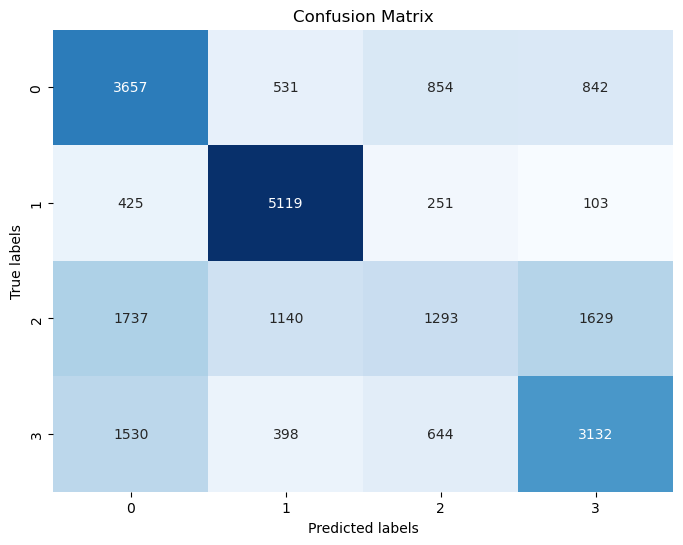


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.50      0.62      0.55      5884
           2       0.71      0.87      0.78      5898
           3       0.43      0.22      0.29      5799
           4       0.55      0.55      0.55      5704

    accuracy                           0.57     23285
   macro avg       0.55      0.57      0.54     23285
weighted avg       0.55      0.57      0.55     23285



In [34]:
conf_matrix = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

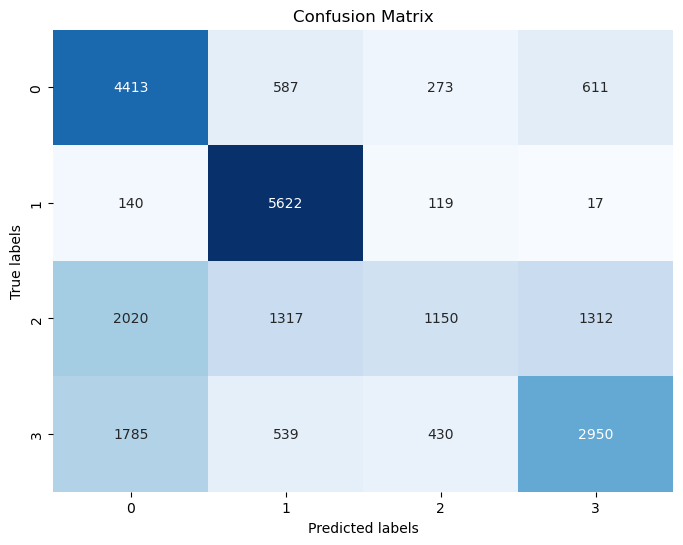


Classification Report for SVM:
              precision    recall  f1-score   support

           1       0.53      0.75      0.62      5884
           2       0.70      0.95      0.81      5898
           3       0.58      0.20      0.30      5799
           4       0.60      0.52      0.56      5704

    accuracy                           0.61     23285
   macro avg       0.60      0.60      0.57     23285
weighted avg       0.60      0.61      0.57     23285



In [38]:
"""
conf_matrix = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred_svm))
"""

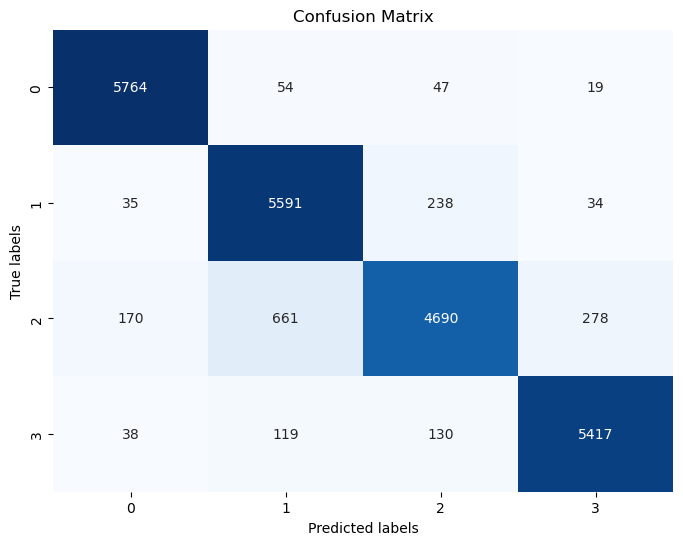


Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.96      0.98      0.97      5884
           2       0.87      0.95      0.91      5898
           3       0.92      0.81      0.86      5799
           4       0.94      0.95      0.95      5704

    accuracy                           0.92     23285
   macro avg       0.92      0.92      0.92     23285
weighted avg       0.92      0.92      0.92     23285



In [35]:
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

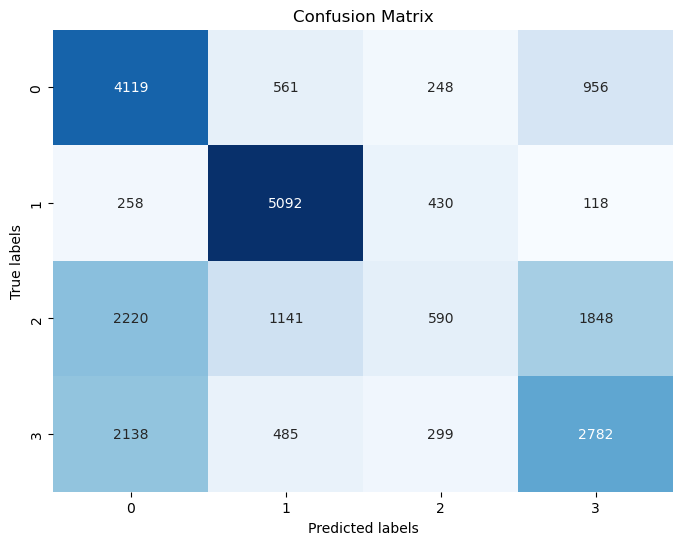


Classification Report for Adaboost:
              precision    recall  f1-score   support

           1       0.47      0.70      0.56      5884
           2       0.70      0.86      0.77      5898
           3       0.38      0.10      0.16      5799
           4       0.49      0.49      0.49      5704

    accuracy                           0.54     23285
   macro avg       0.51      0.54      0.50     23285
weighted avg       0.51      0.54      0.50     23285



In [36]:
conf_matrix = confusion_matrix(y_test, y_pred_adaboost)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report for Adaboost:")
print(classification_report(y_test, y_pred_adaboost))

In conclusion, we can see that ML models are able to effectively model and classify the Severity of an Accident. Not all models are good at the classification task. Models can be further fine-tuned to improve accuracy.